In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from tensorflow import keras 

from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report, roc_auc_score, roc_curve
from sklearn.utils import class_weight
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras import regularizers
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#from keras.applications.mobilenet import MobileNet
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve
#from sklearn.metrics import auc
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_dir='/content/drive/MyDrive/train'

In [ ]:
imageSize=224
# ['DME', 'CNV', 'NORMAL', '.DS_Store', 'DRUSEN']
from tqdm import tqdm
# Create a function to load the data and labels
def get_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder  +'/'+ folderName)):
                img_file = cv2.imread(folder +'/'+ folderName + '/' + image_filename)
                if img_file is not None: 
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
#X_train, y_train = get_data(train_dir) # Un-comment to use full dataset: Step 1 of 2
X, y = get_data(train_dir)
print(len(X),"-----", len(y))



100%|██████████| 1000/1000 [01:02<00:00, 15.89it/s]


4000 ----- 4000


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data to train and test folders
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 


In [ ]:
from numpy.core.multiarray import result_type
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy',allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("./confusion matrix.png")   

def plot_learning_curve(history,modelName,accuracyValeur):
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.text(0.5, 0.5, accuracyValeur)
    plt.title('model accuracy: '+modelName)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("./accuracy_curve.png")
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss: '+modelName)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("./loss_curve.png")               

In [ ]:
from keras.applications.vgg16 import VGG16
from sklearn.utils import class_weight
from keras.utils.vis_utils import plot_model
import tensorflow as tf
map_characters1 = {0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}

#pretrained_model_1 = VGG16(weights ='imagenet', include_top=False, input_shape=(imageSize, imageSize, 3))

pretrained_model_2 = InceptionV3(weights = 'imagenet', include_top=False, input_shape=(imageSize, imageSize, 3))
def pretrainedNetwork(xtrain,ytrain,xtest,ytest,numclasses,numepochs,labels):
    base_model = pretrained_model_2 # Topless
    # Add top layer
    x = base_model.output 
    x = Flatten()(x)
    x = Dropout(0.75)(x)
    #x=Dense(32,kernel_regularizer=regularizers.l1(0.01),activation="reu")l(x)
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False

    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
                  loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy']) 
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    # Fit model
    history = model.fit(xtrain,ytrain, epochs=numepochs, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])

    model.save('modelOctInceptionV3.h5')
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    Y_pred_classes = np.argmax(y_pred, axis = 1) 
    target=list(labels.values())
    print(classification_report(ytest, Y_pred_classes, target_names=target))
    # Y_true = np.argmax(ytest, axis=1) 
    modelNam='InceptionV3'
    confusion_mtx = confusion_matrix(ytest, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history,modelNam,score[1])
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()



87924736/87910968 [==============================] - 0s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

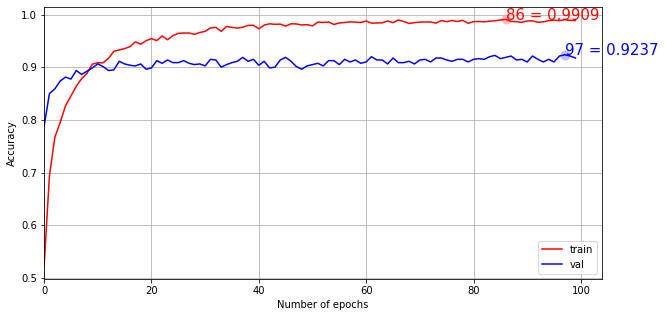

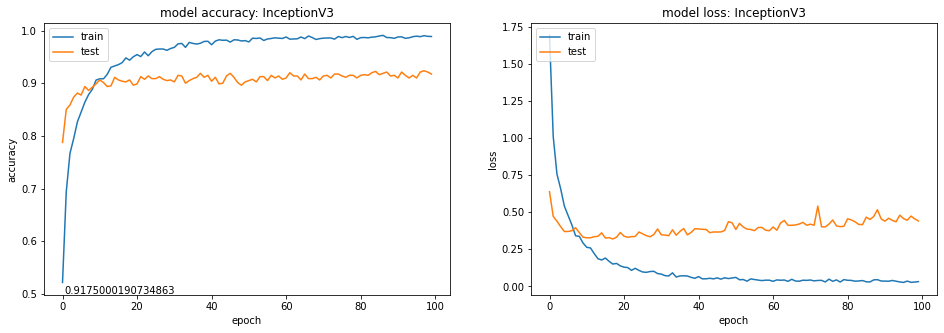

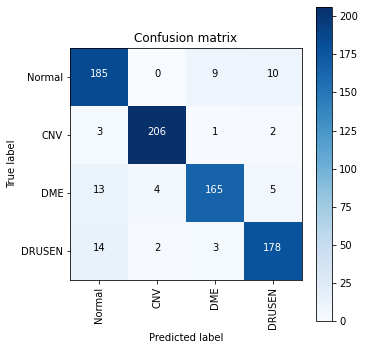

In [ ]:
pretrainedNetwork(X_train,y_train,X_test,y_test,4,100,map_characters1)

In [ ]:
from keras.models import load_model
import cv2
import numpy as np

loaded_model = load_model('modelOctInceptionV3.h5')

loaded_model.layers[0].input_shape

[(None, 224, 224, 3)]

In [ ]:
import skimage
from skimage.transform import resize
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
def predictImage(path):
  img=cv2.imread(path)
  img_file = skimage.transform.resize(img, (224, 224, 3))
  img_arr = np.asarray(img_file)
  img_arr = np.expand_dims(img_arr, axis = 0) 
  yclass=loaded_model.predict(img_arr)
  print("probability===>",yclass)
  ypred=np.argmax(yclass, axis = 1) 
  print(ypred)
  predection=''
  if ypred==0:
    predection='NORMAL'
  elif ypred==1: 
    predection='CNV'
  elif ypred==2:
    predection='DME'
  elif ypred==3:
    predection='DRUSEN'
  else:
    predection='NONE'
  print("predection result===>",predection)
  plt.axis("off")
  plt.imshow(img)


probability===> [[1.3755298e-17 1.0000000e+00 5.2175020e-09 9.5211161e-10]]
[1]
predection result===> CNV


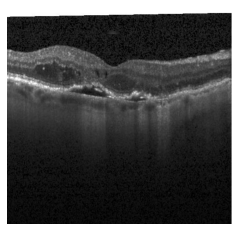

In [ ]:
predictImage('/content/CNV-103044-96.jpeg')